### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, mannwhitneyu

import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score



from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from imblearn.over_sampling import SMOTE, base as over_samp
from imblearn.under_sampling import TomekLinks, base as under_samp

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

TARGET_NAME = 'Credit Default'

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Обзор обучающего датасета

In [4]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [8]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


### Обработка выбросов

#### train датасет

In [9]:
# train датасет
df_train.loc[df_train['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
df_train['Maximum Open Credit'].median()

In [10]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = \
df_train['Current Loan Amount'].median()

In [11]:
df_train.loc[df_train['Credit Score'] > 999, 'Credit Score'] /= 10

#### test датасет

In [12]:
# test датасет
df_test.loc[df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
df_test['Maximum Open Credit'].median()

In [13]:
df_test.loc[df_test['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = \
df_test['Current Loan Amount'].median()

In [14]:
df_test.loc[df_test['Credit Score'] > 999, 'Credit Score'] /= 10

### Обработка пропусков

In [15]:
def show_empty_count(df):
    count = 0
    columns = df.columns
    shape = df.shape
    len_of_column_name = max([len(i) for i in columns])
    columns_with_empties = []
    
    for i in columns:
        if df[i].count() < shape[0]:
            print(f'{i}{" " * (len_of_column_name - len(i))} -- {shape[0] - df[i].count()} -- {df[i].dtype}')
            columns_with_empties.append(i)
            count += 1

    print(f'\nОбщее количество столбцов с пропусками: {count}')
    
    return columns_with_empties

In [16]:
columns_in_train_df_with_empties = show_empty_count(df_train)

Annual Income                -- 1557 -- float64
Years in current job         -- 371 -- object
Months since last delinquent -- 4081 -- float64
Bankruptcies                 -- 14 -- float64
Credit Score                 -- 1557 -- float64

Общее количество столбцов с пропусками: 5


In [17]:
columns_in_test_df_with_empties = show_empty_count(df_test)

Annual Income                -- 513 -- float64
Years in current job         -- 86 -- object
Months since last delinquent -- 1358 -- float64
Bankruptcies                 -- 3 -- float64
Credit Score                 -- 513 -- float64

Общее количество столбцов с пропусками: 5


In [18]:
def fill_empties(df, columns):
    for i in columns:
        if df[i].dtype == 'float64':
            df.loc[df[i].isna(), i] = df[i].median()

        elif df[i].dtype == 'object':
            df.loc[df[i].isna(), i] = df[i].mode()[0]

In [19]:
fill_empties(df_train, columns_in_train_df_with_empties)
fill_empties(df_test, columns_in_test_df_with_empties)

In [20]:
for column in df_train.select_dtypes(include='object').columns:
    print(str(df_train[column].value_counts()) + '*' * 50 + '\n')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64**************************************************

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64**************************************************

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64**************************************************

Short Term    5556
Lon

### Построение новых признаков

In [21]:
df_train_for_analyze = df_train.copy()
df_test_for_analyze = df_test.copy()

In [22]:
df_train_for_analyze['Id'] = df_train_for_analyze.index
df_test_for_analyze['Id'] = df_test_for_analyze.index

In [23]:
def find_str_cat_features(df):
    df_train_objects = df.select_dtypes(include='object').columns
    objects_columns_name = {i: list(df[i].unique()) for i in df_train_objects}

    for key, value in objects_columns_name.items():
        objects_columns_name[key] = dict(zip(value, range(len(value))))
        
    return objects_columns_name

In [24]:
def convert_cat_features_from_str_to_int(df):
    for column_name, values_to_replace in find_str_cat_features(df).items():
        df[column_name].replace(values_to_replace, inplace=True)
        print(column_name + '\n' + '-' * 50 + '\n')
        for k, v in values_to_replace.items():
            print(f'{k} - {v}\n')
        print('*' * 50 + '\n')

In [25]:
convert_cat_features_from_str_to_int(df_train_for_analyze)
convert_cat_features_from_str_to_int(df_test_for_analyze)

Home Ownership
--------------------------------------------------

Own Home - 0

Home Mortgage - 1

Rent - 2

Have Mortgage - 3

**************************************************

Years in current job
--------------------------------------------------

10+ years - 0

8 years - 1

6 years - 2

7 years - 3

5 years - 4

1 year - 5

< 1 year - 6

4 years - 7

3 years - 8

2 years - 9

9 years - 10

**************************************************

Purpose
--------------------------------------------------

debt consolidation - 0

other - 1

home improvements - 2

take a trip - 3

buy a car - 4

small business - 5

business loan - 6

wedding - 7

educational expenses - 8

buy house - 9

medical bills - 10

moving - 11

major purchase - 12

vacation - 13

renewable energy - 14

**************************************************

Term
--------------------------------------------------

Short Term - 0

Long Term - 1

**************************************************

Home Ownership
------

### Анализ данных

In [26]:
def correlation_with_base_features(df, base_features_name, target_name):
    corr_with_target = df[base_features_name + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    
    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
    
    plt.title('Корреляция с целевой переменной')
    
    plt.show()

In [27]:
df_train_for_analyze.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
0,0,482087.0,0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,0,0,309573.0,47386.0,7914.0,749.0,0,0
1,0,1025487.0,0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,0,1,264968.0,394972.0,18373.0,737.0,1,1
2,1,751412.0,1,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,0,0,309573.0,308389.0,13651.0,742.0,0,2
3,0,805068.0,2,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,0,0,121396.0,95855.0,11338.0,694.0,0,3
4,2,776264.0,1,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,0,0,125840.0,93309.0,7180.0,719.0,0,4


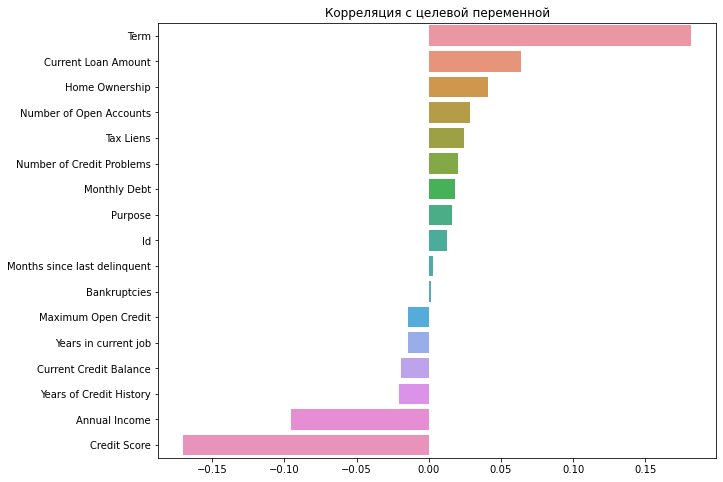

In [28]:
BASE_FEATURES_NAME = \
df_train_for_analyze.select_dtypes(exclude='uint8').columns.drop(TARGET_NAME).to_list()

correlation_with_base_features(df_train_for_analyze, BASE_FEATURES_NAME, TARGET_NAME)

#### Оценака признака Home Ownership в разрезе целевой переменной

In [29]:
def count_p_value(df, column_name, feature_values_in):
    home_ownership_and_target = df.loc[df[column_name].isin(feature_values_in), 
                                             ['Id', column_name, TARGET_NAME]
                                            ]

    table = home_ownership_and_target.pivot_table(values='Id', 
                                                  index=column_name, 
                                                  columns=TARGET_NAME, 
                                                  aggfunc='count')
    chi2, p, _, _ = chi2_contingency(table)
    
    return p

In [30]:
def count_plot(x, hue, data):
    
    plt.figure(figsize=(10, 8))

    sns.countplot(x=x, hue=hue, data=data)

    plt.title(f'{x}')
    plt.legend(title='Target', loc='upper right')

    plt.show()

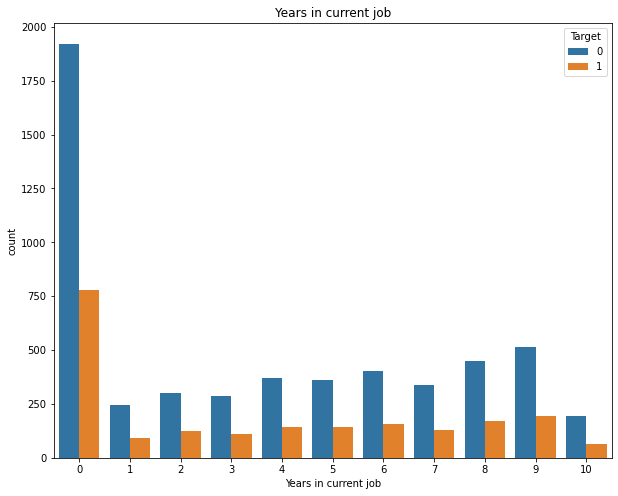

In [31]:
count_plot('Years in current job', TARGET_NAME, df_train_for_analyze)

In [32]:
p = count_p_value(df=df_train_for_analyze, 
                      column_name='Years in current job', 
                      feature_values_in=[5, 6])
p

0.9650101046784189

In [33]:

def clean_string(x):
    
    try:
        x = int(re.findall(r'\d+', x)[0])
    except TypeError:
        pass
    
    return x

In [34]:
def clean_df_column_values(df):
    
    return df['Years in current job'].apply(clean_string)

In [35]:
df_train['Years in current job'] = clean_df_column_values(df_train)

In [36]:
def kdeplot(df, column):
    feature_with_target = df[[column, TARGET_NAME]]
    feature = feature_with_target[column]
    feature_with_target_0 = feature[feature_with_target[TARGET_NAME] == 0]
    feature_with_target_1 = feature[feature_with_target[TARGET_NAME] == 1]
    
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(feature_with_target_0, shade=True, label='Погашен', color='g')
    sns.kdeplot(feature_with_target_1, shade=True, label='Просрочка', color='r')
    
    plt.xlabel(column + '\n' + 'mann whitneyu p_value = ' + \
               str(mannwhitneyu(feature_with_target_0, feature_with_target_1)))
    plt.title(f'{column} grouped by target variable')
    plt.show()

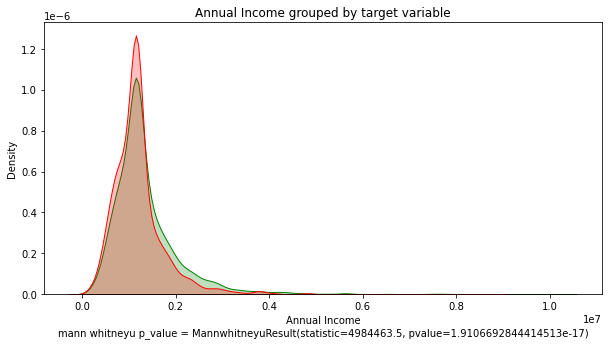

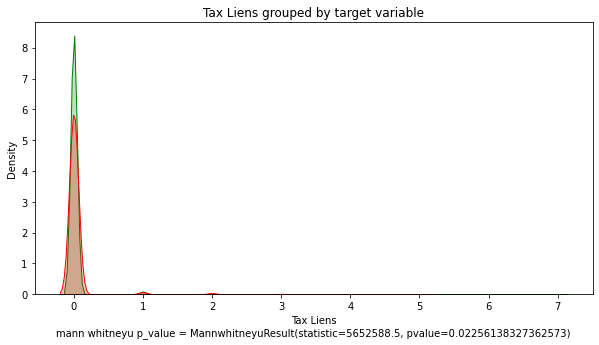

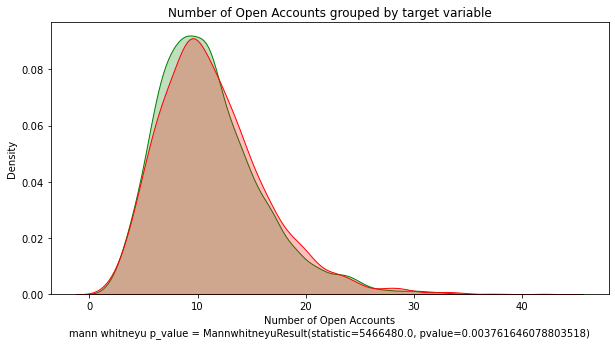

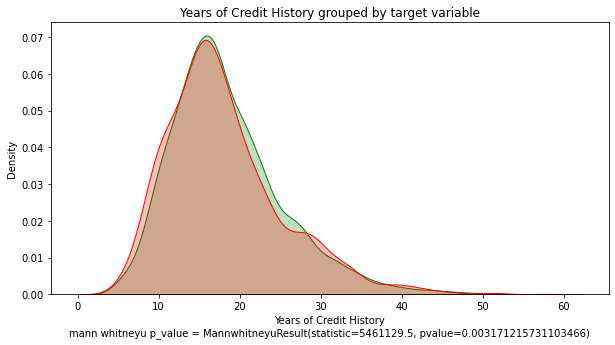

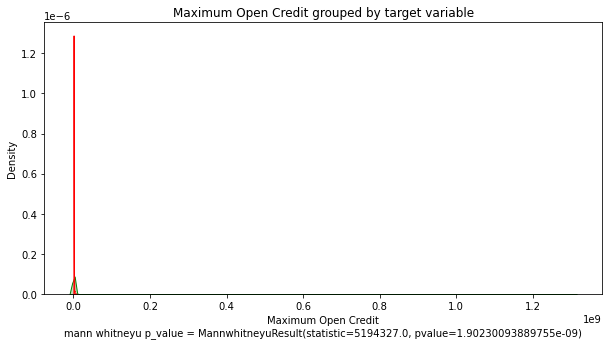

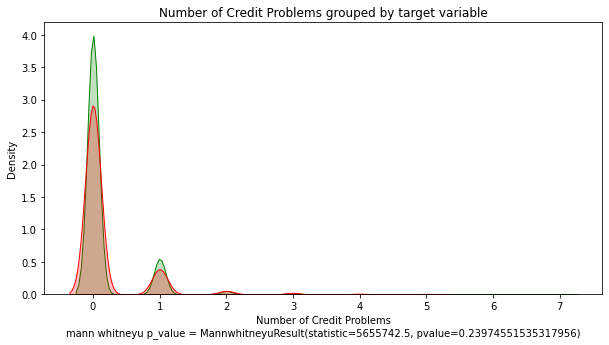

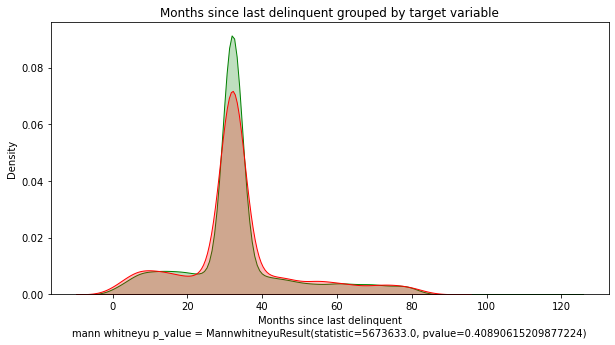

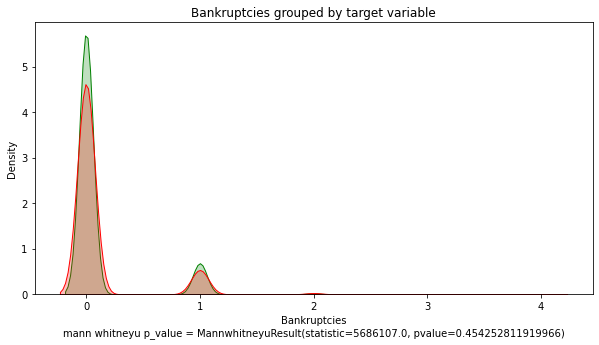

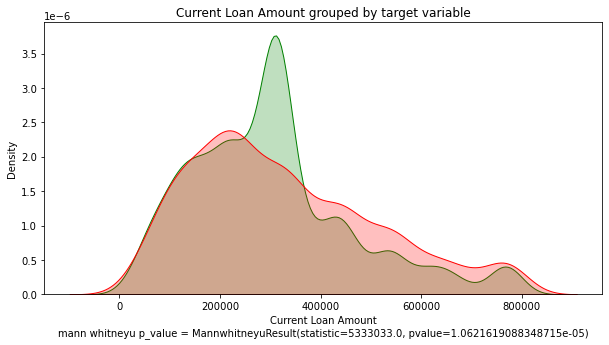

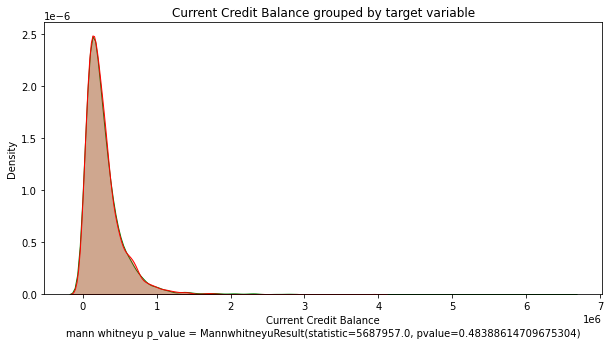

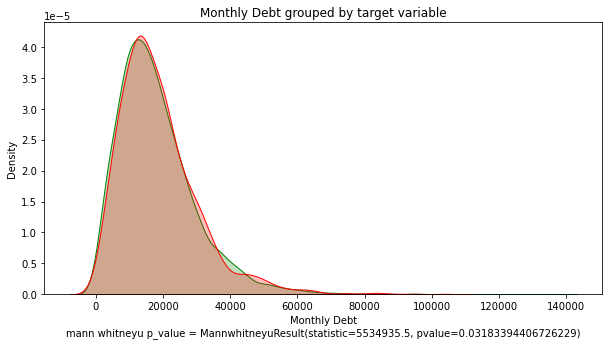

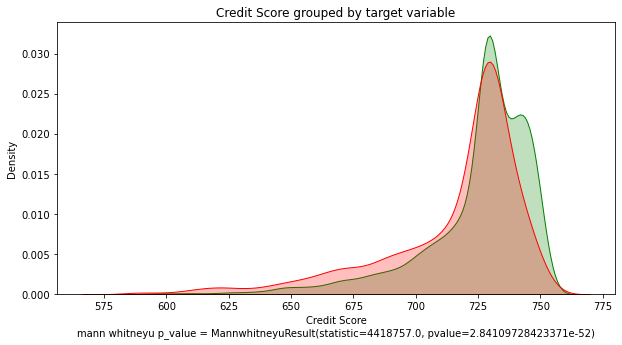

In [37]:
for column in df_train_for_analyze.select_dtypes(exclude='int64'):
    kdeplot(df_train_for_analyze, column)

### Отбор признаков

### Интерпретация результатов

In [38]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [39]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [40]:
counts = df_train[TARGET_NAME].value_counts()

In [41]:
disbalance = counts[0] / counts[1]
disbalance

2.549455750118315

In [42]:
CAT_FEATURES_NAME = df_train.select_dtypes(include='object').columns.tolist()

In [43]:
convert_cat_features_from_str_to_int(df_train)
convert_cat_features_from_str_to_int(df_test)

Home Ownership
--------------------------------------------------

Own Home - 0

Home Mortgage - 1

Rent - 2

Have Mortgage - 3

**************************************************

Purpose
--------------------------------------------------

debt consolidation - 0

other - 1

home improvements - 2

take a trip - 3

buy a car - 4

small business - 5

business loan - 6

wedding - 7

educational expenses - 8

buy house - 9

medical bills - 10

moving - 11

major purchase - 12

vacation - 13

renewable energy - 14

**************************************************

Term
--------------------------------------------------

Short Term - 0

Long Term - 1

**************************************************

Home Ownership
--------------------------------------------------

Rent - 0

Home Mortgage - 1

Own Home - 2

Have Mortgage - 3

**************************************************

Years in current job
--------------------------------------------------

4 years - 0

1 year - 1

3 years - 2



In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [68]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [69]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURES_NAME,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [70]:
model_catb = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [71]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      3771
           1       0.42      0.72      0.53      1479

    accuracy                           0.64      5250
   macro avg       0.63      0.66      0.62      5250
weighted avg       0.73      0.64      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      1616
           1       0.42      0.71      0.53       634

    accuracy                           0.64      2250
   macro avg       0.63      0.66      0.62      2250
weighted avg       0.72      0.64      0.66      2250



In [72]:
final_model_catb = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5)
final_model_catb.fit(X, y, plot=True, eval_set=(X, y))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [99]:
df_test_predicts = final_model_catb.predict(df_test)

In [100]:
PREDICTIONS_FILE_NAME = 'ARassilov_predictions.csv' 

In [101]:
predictions = pd.DataFrame(df_test_predicts, columns=['Predictions'])

In [103]:
predictions.to_csv(PREDICTIONS_FILE_NAME)